In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
import seaborn as sns

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station=Base.classes.station
measurement=Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

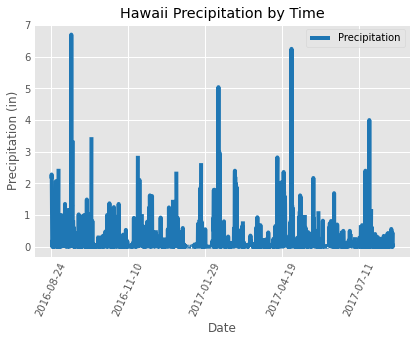

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
for i in last_date:
    date_time_obj = dt.date.fromisoformat(i)

year_ago =  dt.date(date_time_obj.year,date_time_obj.month,date_time_obj.day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp=session.query(measurement).\
    filter(measurement.date > str(year_ago)).all()

d={'Date':[],'Precipitation':[]}
for i in prcp:
    d['Date'].append(i.date)
    d['Precipitation'].append(i.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(d,index=d['Date'],columns=['Precipitation'])

# Sort the dataframe by date
sorted_df=df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('ggplot')
sorted_df.plot.line(color='tab:blue')
plt.xlabel('Date')
plt.xticks(rotation=65)
plt.ylabel('Precipitation (in)')
plt.title("Hawaii Precipitation by Time")
plt.savefig('img/precip.png',bbox_inches='tight')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats=sorted_df.describe()
dfi.export(prcp_stats,'img/prcp_stats.png')
prcp_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(measurement.station).distinct().count()
station_count

9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=func.count(measurement.station).label('station_count')

station_activity=session.query(measurement.station, station_count)\
.group_by(measurement.station).order_by(station_count.desc()).all()

d={'Station':[],'# of Rows':[]}
for i in station_activity:
    d['Station'].append(i.station)
    d['# of Rows'].append(i.station_count)

station_df=pd.DataFrame(d)
dfi.export(station_df,'img/station_count.png')
station_df

,Station,# of Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_min=func.min(measurement.tobs).label('station_min')
station_max=func.max(measurement.tobs).label('station_max')
station_mean=func.avg(measurement.tobs).label('station_mean')

busy_station=session.query(measurement.station, station_min,station_max,station_mean)\
.filter(measurement.station=='USC00519281').all()
    
d={'Most Active Station':[],'Lowest Temp (F)':[],'Highest Temp (F)':[],'Average Temp (F)':[]}
for i in busy_station:
    d['Most Active Station'].append(i.station)
    d['Lowest Temp (F)'].append(i.station_min)
    d['Highest Temp (F)'].append(i.station_max)
    d['Average Temp (F)'].append(i.station_mean)

active_df=pd.DataFrame(d)
dfi.export(active_df,'img/active_station.png')
active_df

,Most Active Station,Lowest Temp (F),Highest Temp (F),Average Temp (F)
0,USC00519281,54.0,85.0,71.663781


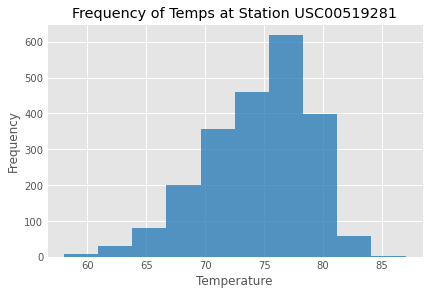

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_count=func.count(measurement.tobs).label('tobs_count')

tobs_activity=session.query(measurement.station, tobs_count)\
.group_by(measurement.station).order_by(tobs_count.desc()).all()

d={'Station':[],'# of Temps':[]}
for i in tobs_activity:
    d['Station'].append(i.station)
    d['# of Temps'].append(i.tobs_count)

tobs_df=pd.DataFrame(d)
dfi.export(tobs_df,'img/station_count.png')

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date,measurement.station)\
.filter(measurement.station=='USC00519281').all()

for i in last_date:
    date_time_obj = dt.date.fromisoformat(i.date)

year_ago =  dt.date(date_time_obj.year,date_time_obj.month,date_time_obj.day) - dt.timedelta(days=365)

# Perform a query to retrieve the temperature data
tobs=session.query(measurement.date,measurement.station,measurement.tobs)\
.filter(measurement.date > str(year_ago))\
.filter(measurement.station=='USC00519281').all()

d={'Date':[],'Temperature':[]}
for i in prcp:
    d['Date'].append(i.date)
    d['Temperature'].append(i.tobs)

temp_df=pd.DataFrame(d)

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('ggplot')
temp_df.hist(column='Temperature', color='tab:blue',alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Frequency of Temps at Station USC00519281")
plt.savefig('img/temps.png',bbox_inches='tight')


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
